## Logistic matrix factorization

Please see the comments below for more information on the source code.

In [333]:
#importing required libraries
import numpy as np
import pandas as pd
import numpy as np
from matplotlib.pyplot import imshow
from scipy.stats import uniform
import matplotlib.pyplot as plt
from scipy.stats import norm, bernoulli
%matplotlib inline

### Question 1

Below are the helper functions needed throughout the notebook

In [705]:
def sample_column_vector(size=1, dist="G"):
    if "G":
        return norm(0, 5).rvs(size=size).reshape(size,-1)
    if "U":
        return uniform(-1,2).rvs(size=size).reshape(size, -1)
def binarize(Y):
    Y[Y<=0] = 0
    Y[Y>0] = 1
    return Y
def bernoulli_matrix(Y):
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = bernoulli(Y[i, j]).rvs()
    return Y
def create_observation_matrix(I=10, J=20):
    W = sample_column_vector(size=I)
    H = sample_column_vector(size=J)
    Y = bernoulli_matrix(sigmoid(W @ H.T))
    return Y, W, H
def sigmoid(o):
    return 1. / (1 + np.exp(-o))
def make_sigmoid_matrix(W, H):
    return(sigmoid(W @ H.T))
def log_likelihood(Y, W, H):
    L = Y*np.log(sigmoid(W @ H.T)) + (1-Y)*np.log(1-sigmoid(W @ H.T))
    return L.sum()
def calc_dW(Y, W, H):
    return (Y - make_sigmoid_matrix(W, H)) @ H
def calc_dH(Y, W, H):
    return (Y - make_sigmoid_matrix(W, H)).T @ W
def calc_dW_post(Y, W, H):
    return (Y - make_sigmoid_matrix(W, H)) @ H - W
def calc_dH_post(Y, W, H):
    return (Y - make_sigmoid_matrix(W, H)).T @ W - H
def plot_L_history(L_history):
    fig, ax = plt.subplots(1)
    ax.plot(range(len(L_history)), L_history)
    ax.set_title("Log likelihood through AGD iterations")
def alternating_gradient_descent(Y, W, H, no_iteration=10, eta = 0.01, posterior=False):
    I, J = Y.shape
    L_history = []
    dW = 1; dH = 1;
    for i in range(no_iteration):
    #while (np.abs(dW).sum() + np.abs(dH).sum() > 1):
        if posterior:
            dW = calc_dW_post(Y, W, H)
        else:
            dW = calc_dW(Y, W, H)
        W = W + eta*dW
        if posterior:
            dH = calc_dH_post(Y, W, H)
        else:
            dH = calc_dH(Y, W, H)
        H = H + eta*dH
        L_history.append(log_likelihood(Y, W, H))
    return W, H, L_history  

def evaluate_classification(Y, W, H):
    TP = 0; FP = 0; TN = 0; FN = 0;
    Y_hat = binarize(W @ H.T)
    total = Y.shape.sum()
    for i in Y.shape[0]:
        for j in Y.shape[1]:
            if Y[i,j] == 1:
                if Y_hat[i, j] == 1:
                    TP += 1
                else:
                    FN += 1
            else:
                if Y_hat[i, j] == 1:
                    FP += 1
                else:
                    TN += 1
    accuracy = (TP + TN) / total
    precision = (TP) / (TP + FP)
    recall = (TP) / (TP + FN)
    F1_score = (2*precision*recall)/(precision + recall)
    return accuracy, precision, recall, F1_score   

def plot_matrix_comparison(Y, W, H):
    fig, axes = plt.subplots(1, 2,figsize=(16,32))
    axes[0].imshow(Y);
    axes[1].imshow(make_sigmoid_matrix(W, H));
def run_experiment(I=10, J=20, no_iteration=100, eta = 0.01):
    Y, W_orig, H_orig = create_observation_matrix(I, J)
    W = sample_column_vector(I, dist="U") # sampling initial W H values
    H = sample_column_vector(J, dist="U")
    W, H, L_history = alternating_gradient_descent(Y, W, H, no_iteration, eta)
    return Y, W, H, L_history

def plot_experiment_1(Y, W, H, L_history):
    fig, axes = plt.subplots(2,2, figsize=(14,8))
    axes[0,0].set_title("Log likelihood through iterations")
    axes[0,1].plot(range(len(L_history)), L_history)
    axes[0,0].set_title("Original noisy matrix")
    axes[0,0].imshow(Y)
    axes[1,0].set_title("Reconstruction")
    axes[1,0].imshow(make_sigmoid_matrix(W, H))
    axes[1,1].set_title("Reconstruction binarized")
    axes[1,1].imshow(binarize(W @ H.T))
    axes_tick = [axes[0,0], axes[1,0], axes[1,1]]
    turn_off_ticklabels(axes_tick)
    return fig, axes
def turn_off_ticklabels(axes):
    try :
        for ax in axes.flatten():
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    except AttributeError:
        for ax in axes:
            ax.set_yticklabels([])
            ax.set_xticklabels([])            
def expectation_maximization(Y, present_value_ratio, iterations=200):
    #randomly initiate W and H 
    I = Y.shape[0]
    J = Y.shape[1]
    Y_orig = Y.copy()
    mask = create_mask_matrix(I, J, present_value_ratio)
    W = sample_column_vector(I, dist="U") # sampling initial W H values
    H = sample_column_vector(J, dist="U")
    total_L_history = []
    for i in range(iterations):
        #the E step
        e_step(Y, mask, W, H)
        #the M step
        W, H, L_history = alternating_gradient_descent(Y, W, H, no_iteration=100, eta = 0.01, posterior=True)
        total_L_history += L_history
    return W, H, Y_orig, mask, total_L_history

def plot_expectation_maximization(Y_orig, mask, W, H):
    fig, axes = plt.subplots(2,2, figsize=(14,8))
    axes[0,0].set_title("Original noisy matrix")
    axes[0,0].imshow(Y_orig)
    axes[0,1].set_title("Masked matrix")
    mask_plot= mask.copy()
    mask_plot[mask_plot==0] = np.nan
    current_cmap = matplotlib.cm.get_cmap()
    current_cmap.set_bad(color='white')
    axes[0,1].imshow(Y*(mask_plot))
    axes[1,0].set_title("Reconstruction")
    axes[1,0].imshow(make_sigmoid_matrix(W, H))
    axes[1,1].set_title("Reconstruction binarized")
    axes[1,1].imshow(binarize(W @ H.T))
    turn_off_ticklabels(axes)
    return fig, axes
def create_mask_matrix(I, J, ratio_present):
    mask_matrix = bernoulli(ratio_present).rvs(size=(I,J)).astype(float)
    return mask_matrix

Running the first experiment.

In [702]:
Y, W, H, L_history = run_experiment(I=10, J=20, no_iteration=300, eta = 0.01)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


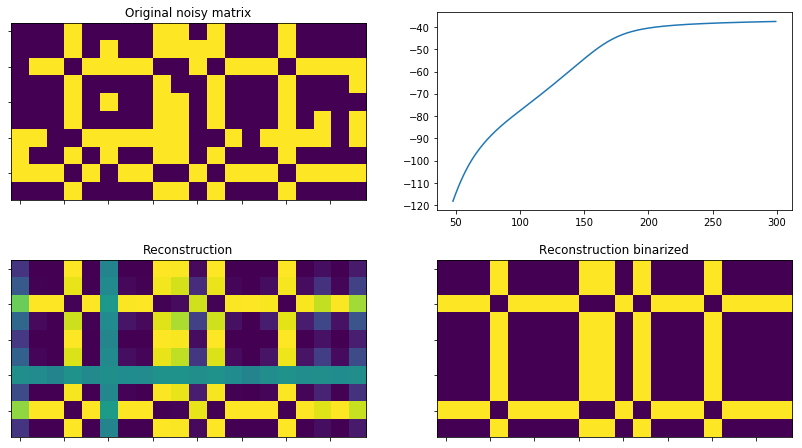

In [706]:
fig, axes= plot_experiment_1(Y, W, H, L_history)
fig.savefig("img/atc_exp_1.png")

### Question 2

Running the second experiment

In [712]:
Y, W_orig, H_orig = create_observation_matrix(I, J)
W, H, Y_orig, mask, total_L_history = expectation_maximization(Y, .80, iterations=100)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


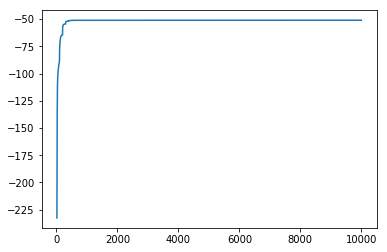

In [713]:
plt.plot(range(len(total_L_history)),total_L_history);
plt.savefig("img/em_log_likelihood")

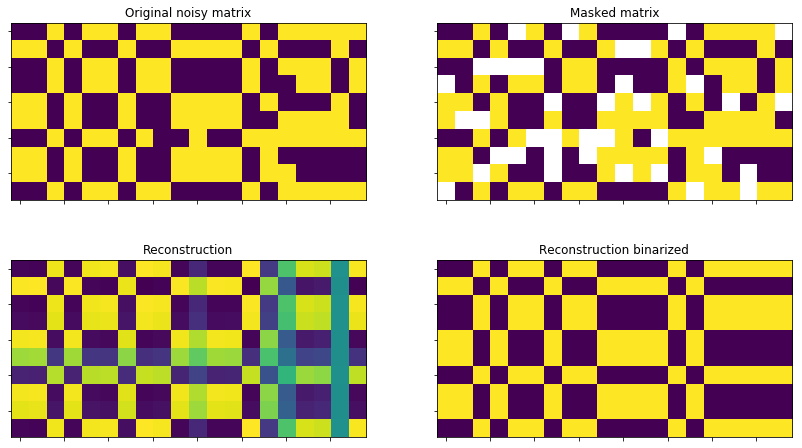

In [714]:
fig, axes = plot_expectation_maximization(Y_orig, mask, W, H)
fig.savefig("img/em_reconstruction.png")

In [636]:
atc_exp_2_results = {"W_orig":W_orig, "H_orig": H_orig, "W_final": W, "H_final": H, "Y_orig": Y_orig, "mask": mask, "total_L_history": total_L_history}

In [638]:
pickle.dump(atc_exp_2_results, open("results/atc_exp_2_results.pkl", "wb"))